# Load Data

In [79]:
# where we will unpack data
# OUTPUT_FOLDER = "/kaggle/working/"
# DATA_FOLDER = "/kaggle/input/solfune-satellite/"
# TRAIN_DATA_FOLDER = DATA_FOLDER + 'train/'

OUTPUT_FOLDER = "/scratch/aakash_ks.iitr/dr-scnn/"
DATA_FOLDER = "/scratch/aakash_ks.iitr/data/diabetic-retinopathy/"
TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train_c/'
# TEST_DATA_FOLDER = DATA_FOLDER + 'test/'

# Imports

In [80]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from PIL import Image

In [81]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2

import timm

In [82]:
NUM_CLASSES = 5

class CFG:
    seed = 42
    N_folds = 5
    train_folds = [0] # [0,1,2,3,4]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    apex=True # use half precision

    # model_name = "maxvit_tiny_tf_512"
    model_name = "resnet50.a1_in1k"
    epochs = 20
    # weights =  torch.tensor([0.206119, 0.793881],dtype=torch.float32)

    clip_val = 1000.
    batch_size = 64
    # gradient_accumulation_steps = 1

    lr = 1e-4
    weight_decay=1e-2
    
    resolution = 224

In [ ]:
import wandb
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb.login(key=user_secrets.get_secret("wandb_api"))

run = wandb.init(
    project="hello-world", 
    dir=OUTPUT_FOLDER,
    config={
    k:v for k, v in CFG.__dict__.items() if not k.startswith('__')}
)

In [83]:
device = torch.device(CFG.device)

# Load train data

In [90]:
train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels_cropped.csv'))
train_data

,Unnamed: 0.1,Unnamed: 0,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1
...,...,...,...,...
35103,35104,35121,44347_right,0
35104,35105,35122,44348_left,0
35105,35106,35123,44348_right,0
35106,35107,35124,44349_left,0


In [91]:
# remove all images from the csv if they are not in the folder
lst = map(lambda x: x[:-5], os.listdir(TRAIN_DATA_FOLDER))
train_data = train_data[train_data.image.isin(lst)]
len(train_data)

19944

In [92]:
train_data.level.value_counts()

level
0    14637
2     2982
1     1405
3      498
4      422
Name: count, dtype: int64

In [93]:
# take only 100 samples from each class
train_data = train_data.groupby('level').head(1000).reset_index(drop=True)
train_data.level.value_counts()

level
1    1000
2    1000
0    1000
3     498
4     422
Name: count, dtype: int64

# Dataset

In [102]:
from torchvision.transforms import functional as func

class CustomTransform:
    def __init__(self, output_size=(CFG.resolution, CFG.resolution), radius_factor=0.9):
        self.output_size = output_size
        self.radius_factor = radius_factor

    def __call__(self, img):
        # Assuming img is a PIL Image
        # Normalize and preprocess as previously defined
        img = func.resize(img, int(min(img.size) / self.radius_factor))
        img_tensor = func.to_tensor(img)
        mean, std = img_tensor.mean([1, 2]), img_tensor.std([1, 2])
        img_normalized = func.normalize(img_tensor, mean.tolist(), std.tolist())
        kernel_size = 15
        padding = kernel_size // 2
        avg_pool = torch.nn.AvgPool2d(kernel_size, stride=1, padding=padding)
        local_avg = avg_pool(img_normalized.unsqueeze(0)).squeeze(0)
        img_subtracted = img_normalized - local_avg
        center_crop_size = int(min(img_subtracted.shape[1:]) * self.radius_factor)
        img_cropped = func.center_crop(img_subtracted, [center_crop_size, center_crop_size])

        # Apply augmentations
        img_resized = func.resize(img_cropped, self.output_size)

        return img_resized

In [103]:
# train_transforms = CustomTransform()

train_transforms = v2.Compose([
    CustomTransform(),
    # v2.RandomResizedCrop(CFG.resolution, scale=(0.8, 1.0)),  # Krizhevsky style random cropping
    v2.RandomHorizontalFlip(),  # Random horizontal flip
    v2.RandomVerticalFlip(),  # Random vertical flip
    v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2)),  # Gaussian blur with random kernel size and sigma
    v2.RandomRotation(degrees=(0, 90)),  # Random rotation between 0 and 360 degrees
    v2.ToDtype(torch.float32, scale=False),
])

val_transforms = v2.Compose([
    CustomTransform(),
    v2.ToDtype(torch.float32, scale=False),
])

In [104]:
class ImageTrainDataset(Dataset):
    def __init__(
        self,
        folder,
        data,
        transforms,
    ):
        self.folder = folder
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data.loc[index]
        image = Image.open(f"{self.folder}{d.image}.jpeg")
        image = self.transforms(image)
        label = d.level

        return image, torch.tensor(label, dtype=torch.long)

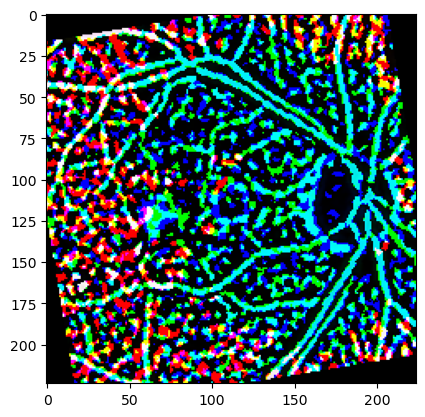

In [129]:
# # visualize the transformations
# train_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, train_data, train_transforms)
# image, label = train_dataset[10]
# transformed_img_pil = func.to_pil_image(image)
# plt.imshow(transformed_img_pil)

# Metric

In [ ]:
from sklearn.metrics import f1_score as sklearn_f1
from sklearn.metrics import confusion_matrix, roc_auc_score

In [ ]:
# def find_best_threshold(targets, predictions):
#     score_5 = sklearn_f1(targets, predictions > 0.5)
#     best_score = 0
#     best_th = -1
#     for i in range(100):
#         threshold =  i/100
#         _score = sklearn_f1(targets, predictions > threshold)
#         if _score > best_score:
#             best_score = _score
#             best_th = threshold

#     tn, fp, fn, tp = confusion_matrix(targets.numpy(), predictions.numpy() > best_th).ravel()
#     print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
#     return score_5, best_score, best_th

# Train and evaluate functions

In [ ]:
class style:
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    END = '\033[0m'
    BOLD = '\033[1m'

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [ ]:
def evaluate_model(cfg, model, data_loader, loss_criterion, epoch=-1):
    # loss_fn = nn.CrossEntropyLoss(weight=cfg.weights.to(device), label_smoothing=0.1)
    loss_fn = loss_criterion

    model.eval()
    val_loss = 0

    targets = []
    predictions = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    for step, (images, labels) in tk0:
        images = images.to(device)
        target = labels.to(device)

        with torch.no_grad():
            logits = model(images)

        loss = loss_fn(logits, target)
        val_loss += loss.item()

        targets.append(target.detach().cpu())
        predictions.append(logits.detach().cpu())
        del images, target, logits

    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)
    predictions = F.sigmoid(predictions)

    val_loss /= total_len
    # base_score, best_score, best_th = find_best_threshold(targets, predictions[:, 1])
    # roc_auc = roc_auc_score(targets.numpy(), predictions[:, 1].numpy())
    roc_auc = 1

    print(f'Epoch {epoch} validation loss = {val_loss:.4f} auc = {roc_auc:.4f}')
    return val_loss, roc_auc

In [ ]:
def train_epoch(cfg, model, train_loader, loss_criterion, optimizer, scheduler, epoch):
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.apex)
    # loss_fn = nn.CrossEntropyLoss(weight=cfg.weights.to(device), label_smoothing=0.1)
    loss_fn = loss_criterion

    model.train()
    train_loss = 0
    learning_rate_history = []

    targets = []
    predictions = []

    total_len = len(train_loader)
    tk0 = tqdm(enumerate(train_loader), total=total_len)
    for step, (images, labels) in tk0:
        images = images.to(device, non_blocking=True)
        target = labels.to(device, non_blocking=True)

        # https://pytorch.org/blog/accelerating-training-on-nvidia-gpus-with-pytorch-automatic-mixed-precision/
        with torch.cuda.amp.autocast(enabled=cfg.apex):
            logits = model(images)
            loss = loss_fn(logits, target)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg.clip_val)

        train_loss += loss.item()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        if scheduler is None:
            lr = optimizer.param_groups[0]['lr']
        else:
            scheduler.step()
            lr = scheduler.get_last_lr()[0]

        tk0.set_description(f"Epoch {epoch} training {step+1}/{total_len} [LR {lr:0.6f}] - loss: {train_loss/(step+1):.4f}")
        learning_rate_history.append(lr)

        targets.append(target.detach().cpu())
        predictions.append(logits.detach().cpu())
        del images, target

    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)
    predictions = F.sigmoid(predictions)

    train_loss /= total_len
    # roc_auc = roc_auc_score(targets.numpy(), predictions[:, 1].numpy())
    roc_auc = 1

    print(f'Epoch {epoch} train loss = {train_loss:.4f}, auc = {roc_auc:.4f}')
    return train_loss, learning_rate_history, roc_auc

# Train model

## Split data

The distribution of classes in the training data is not balance so using StratifiedKFold will ensure that the distrubution of positive and negative samples in all folds will match the original distributions.

In [ ]:
# plt.figure(figsize=(4,2))
# sns.histplot(train_data["label"])

In [ ]:
from sklearn.model_selection import StratifiedKFold

sgkf = StratifiedKFold(n_splits=CFG.N_folds, random_state=CFG.seed, shuffle=True)
for i, (train_index, test_index) in enumerate(sgkf.split(train_data["image"].values, train_data["level"].values)):
    train_data.loc[test_index, "fold"] = i

In [ ]:
# from torchgeo import models
# from torch import nn

In [ ]:
def create_model():
    model = timm.create_model(CFG.model_name, in_chans=3, num_classes=NUM_CLASSES, pretrained=True)

#     model = models.resnet50(models.ResNet50_Weights.SENTINEL2_ALL_DINO)
#     wd = torch.concat([model.conv1.weight[:, :13, ...], model.conv1.weight[:, :7, ...]], dim=1)
#     model.conv1 = nn.Conv2d(20, 64, 7, 2, 3, bias=False)
#     model.conv1.weight = nn.Parameter(wd)
#     model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)

    return model.to(device)

## Train folds

In [ ]:
for FOLD in CFG.train_folds:

    seed_everything(CFG.seed)

    # PREPARE DATA
    fold_train_data = train_data[train_data["fold"] != FOLD].reset_index(drop=True)
    fold_valid_data = train_data[train_data["fold"] == FOLD].reset_index(drop=True)

    # display(
    #     pd.merge(
    #         fold_valid_data.groupby(by=["label"])["file_name"].count().rename("valid").reset_index(),
    #         fold_train_data.groupby(by=["label"])["file_name"].count().rename("train").reset_index(),
    #          on="label", how="left").T,)


    train_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, fold_train_data, transforms=train_transforms)
    valid_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, fold_valid_data, transforms=val_transforms)

    train_loader = DataLoader(
            train_dataset,
            batch_size=CFG.batch_size,
            shuffle=True,
            num_workers=16,
            pin_memory=True,
            drop_last=True
        )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=16,
        pin_memory=True,
        drop_last=False,
    )

    # PREPARE MODEL, OPTIMIZER AND SCHEDULER
    model = create_model()
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):_}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, eta_min=1e-6, T_max =CFG.epochs * len(train_loader),
        )
    
    loss_criterion = nn.CrossEntropyLoss()

    # TRAIN FOLD
    learning_rate_history = []
    train_loss_history = []
    train_score_history = []
    val_loss_history = []
    val_score_history = []

    best_score = 0
    
    wandb.run.tags = [f"fold_{FOLD}"]
    
    for epoch in range(0, CFG.epochs):
        train_loss, train_lr, train_auc = train_epoch(CFG, model, train_loader, loss_criterion, optimizer, scheduler, epoch)
        train_loss_history.append(train_loss)
        train_score_history.append(train_auc)
        learning_rate_history.extend(train_lr)

        val_loss, val_auc = evaluate_model(CFG, model, valid_loader, loss_criterion, epoch)
        val_loss_history.append(val_loss)
        val_score_history.append(val_auc)
        
        wandb.log(
            {'train': {'loss': train_loss, 'auc': train_auc}, 
             'val': {'loss': val_loss, 'auc': val_auc}})

        if (val_auc > best_score):
            print(f"{style.GREEN}New best score: {best_score:.4f} -> {val_auc:.4f}{style.END}")
            best_score = val_auc
            torch.save(model.state_dict(), os.path.join(wandb.run.dir, f'best_model_fold_{FOLD}.pth'))
            
    # run.log_model(
    #     path=os.path.join(wandb.run.dir, 'best_model_fold_{FOLD}'), 
    #     name=f'{CFG.model_name}_fold_{FOLD}'
    # )

    # # plot train and validation loss, score and LR
    # fig, axes = plt.subplots(1,3, figsize=(12,3))
    # axes[0].plot(train_loss_history, label="Train")
    # axes[0].plot(val_loss_history, label="Valid")
    # axes[0].title.set_text("Loss")
    # axes[0].set_xlabel("Epoch")
    # axes[0].legend()

    # axes[1].plot(train_score_history, label="Train")
    # axes[1].plot(val_score_history, label="Valid")
    # axes[1].title.set_text("F1 score")
    # axes[1].set_xlabel("Epoch")
    # axes[1].legend()

    # axes[2].plot(learning_rate_history, label="LR")
    # axes[2].legend()
    # axes[2].title.set_text("Learning rate")
    # axes[2].set_xlabel("Step")
    # fig.suptitle(f"Fold {FOLD}")
    # fig.tight_layout()
    # plt.show()

In [ ]:
wandb.finish()